[TFL's documentation](https://tfl.gov.uk/info-for/open-data-users/our-open-data?intcmp=3671)

# Import

In [1]:
import pandas
import matplotlib
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import figs
figs.set_rc()
%matplotlib inline

In [2]:
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['pgf.texsystem'] = 'pdflatex'

In [3]:
raw = pandas.read_csv('../data/tfl_raw.csv')
raw.head()

,downo,daytype,SubSystem,StartStn,EndStation,EntTime,EntTimeHHMM,ExTime,EXTimeHHMM,ZVPPT,JNYTYP,DailyCapping,FFare,DFare,RouteID,FinalProduct
0,3,Tue,LUL,Unstarted,Kings Cross M,0,00:00,633,10:33,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day
1,4,Wed,LUL,Unstarted,Sudbury Hill,0,00:00,447,07:27,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
2,3,Tue,NR,Unstarted,Richmond,0,00:00,966,16:06,Z0304,TKT,N,0,0,XX,LUL Travelcard-7 Day
3,4,Wed,NR,Unstarted,Romford,0,00:00,657,10:57,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
4,6,Fri,NR,Unstarted,Norwood Junction SR,0,00:00,450,07:30,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day


# Combine stations

See Locations notebook for details.

In [4]:
combine = (
    ('Balham', 'Balham NR', 'Balham SCL'),
    ('Canary Wharf', 'Canary Wharf DLR', 'Canary Wharf E2'),
    ('Euston', 'Euston NR'),
    ('Fenchurch St NR', 'FENCHURCH ST NR'),
    ("Kings Cross St Pancras", 'Kings Cross', 'Kings Cross M', 'Kings Cross T', 'St Pancras International'),
    ('Liverpool Street', 'Liverpool St WAGN TOC Gates', 'Liverpool St NR'),
    ('Marylebone', 'Marylebone NR'),
    ('Paddington', 'Paddington FGW'),
    ('Shepherds Bush', "Shepherd's Bush NR", "Shepherd's Bush Und"),
    ('Shepherds Bush Market', "Shepherd's Bush Mkt"),
    ('Tottenham Court Road', 'Tottenham Court Rd'),
    ('West Hampstead', "West Hampst'd NL", "West Hampst'd Tlink"),
    ('Victoria', 'Victoria TOCs'),
    ('Waterloo', 'Waterloo JLE'),
    ('Blackhorse Lane TRAM', 'BLCKHRS LNE TRAM'),
    ('Caledonian Road & Barnsbury', "Caledonian Rd&B'sby"),
    ('New Addington TRAM', 'NEW ADDNGTH TRAM'),
    ('Beckenham Road TRAM', 'BECKENHM RD TRAM'),
    ('Harringay Green Lanes', 'Harringay Green Las'),
    ('Sudbury & Harrow Rd', 'Sudbury&Harrow Rd'),
    ('Walthamstow Queens Road', 'Walthamstow Qns R'),
    ('Belgrave Walk TRAM', 'BELGRAVE WK TRAM'),
    ('Addington Village TRAM', 'ADDNGTN VIL TRAM'),
    ('Wimbledon', 'WIMBLEDON TRAM'),
)
substitutions = {}
for i in combine:
    for name in i[1:]:
        substitutions[name] = i[0]

Apply substitutions to the data

In [5]:
raw['StartStn'] = raw['StartStn'].str.strip()
raw['EndStation'] = raw['EndStation'].str.strip()
raw['StartStn'].replace(substitutions, inplace=True)
raw['EndStation'].replace(substitutions, inplace=True)

# Validity

In [6]:
complete_journeys = raw[raw['SubSystem'] != 'LTB'][raw['SubSystem'] != 'TRAM'][raw['SubSystem'] != 'LUL/TRAM'][raw['StartStn'] != 'Unstarted'][raw['EndStation'] != 'Unfinished'][raw['EndStation'] != 'Not Applicable']

/mnt/c/Users/Josh/Google Drive_old/Uni/Part III/project/data/env/lib/python3.4/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [7]:
raw[raw['SubSystem'] != 'LTB'][raw['SubSystem'] != 'TRAM'][raw['SubSystem'] != 'LUL/TRAM'][raw['EndStation'] == 'Not Applicable'].count()

/mnt/c/Users/Josh/Google Drive_old/Uni/Part III/project/data/env/lib/python3.4/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


downo           1
daytype         1
SubSystem       1
StartStn        1
EndStation      1
EntTime         1
EntTimeHHMM     1
ExTime          1
EXTimeHHMM      1
ZVPPT           1
JNYTYP          1
DailyCapping    1
FFare           1
DFare           1
RouteID         1
FinalProduct    1
dtype: int64

In [8]:
all_stations = complete_journeys['StartStn'].append(complete_journeys['EndStation']).unique()

# By hour

In [9]:
complete_journeys['EntTimeHHMM']=complete_journeys['EntTimeHHMM'].str.slice(0,2)

## By start and end

In [10]:
start_end_by_hour = complete_journeys.groupby(('StartStn', 'EndStation','daytype', 'EntTimeHHMM')).size()
start_end_by_hour = start_end_by_hour.reset_index()
start_end_by_hour.columns = ['Start station', 'End station', 'Day', 'Entry hour', 'Journey count']
start_end_by_hour.head(7)

,Start station,End station,Day,Entry hour,Journey count
0,Acton Central,Acton Central,Sat,18,1
1,Acton Central,Acton Central,Sun,07,1
2,Acton Central,Acton Central,Thu,13,1
3,Acton Central,Acton Central,Wed,17,1
4,Acton Central,Baker Street,Mon,07,1
5,Acton Central,Baker Street,Thu,08,1
6,Acton Central,Baker Street,Tue,08,1


### Checking

Should both be 765324

In [11]:
start_end_by_hour['Journey count'].sum()

764605

In [12]:
complete_journeys.shape[0]

764605

### Output

In [13]:
# start_end_by_hour.to_csv('../data/journey_count.csv', index=False)

# By days

In [14]:
by_day_time = complete_journeys.groupby(('EntTimeHHMM', 'downo')).size()
by_day_time = by_day_time.reset_index()
by_day_time.columns = ['time', 'day', 'journeys']
by_day_time['time'] = pandas.to_numeric(by_day_time['time'])
by_day_time['day'] -= 1

In [15]:
complete_journeys.groupby(('downo', 'daytype')).size()

downo  daytype
1      Sun         42255
2      Mon        124155
3      Tue        130024
4      Wed        132751
5      Thu        133555
6      Fri        131141
7      Sat         70724
dtype: int64

/mnt/c/Users/Josh/Google Drive_old/Uni/Part III/project/data/env/lib/python3.4/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


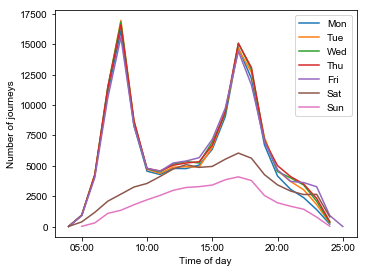

In [23]:
figs.set_size(5.2, .75)
ax = plt.subplot(xlabel='Time of day', ylabel='Number of journeys',)
for i, day in enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']):
    daynum = (i + 1) % 7
    dat = by_day_time[by_day_time['day']==daynum]
    dat.plot(x='time', y='journeys', ax=ax, label=day)

ax.set_xlabel('Time of day')
ax.set_xticklabels(['{:0>2}:00'.format(int(x)) for x in ax.get_xticks()]);
plt.savefig('../../figs/Fig5.tif')

# Start and end locations

In [17]:
all_station_index = pandas.MultiIndex.from_product(
    (all_stations, all_stations),
    names=('StartStn', 'EndStation')
)
by_start_end = pandas.Series(
    data=complete_journeys.groupby(('StartStn', 'EndStation')).size(),
    index=all_station_index
).unstack().fillna(0)

In [18]:
borough_table = pandas.read_csv('../data/station_borough.csv').set_index('Station')
lookup = dict(borough_table['Local authority'])

# Graph visulisation

In [19]:
import numpy as np
from sklearn.manifold import MDS
def form_coords_df(move_df):
    dissim = (1 - move_df)
    np.fill_diagonal(dissim.values, 0)
    dissim += dissim.T
    dissim /= 2
    sim = 1 - dissim
    mds = MDS(metric=False, dissimilarity='precomputed', random_state=3)
    coords = mds.fit_transform(dissim.values)
    coords_df = pandas.DataFrame(
        data=coords,
        index=all_stations,
        columns=('x', 'y')
    ).merge(borough_table, left_index=True, right_index=True)
    coords_df['connectivity'] = sim.sum()
    return coords_df, sim

In [20]:
from matplotlib.collections import LineCollection
# from: https://stackoverflow.com/questions/53699012/performant-cartesian-product-cross-join-with-pandas
def cartesian_product_basic(left, right):
    return (
       left.assign(key=1).merge(right.assign(key=1), on='key')
        .drop('key', 1)
    )
def self_join(df):
    return cartesian_product_basic(df, df)

def create_lines(df, sim):
    excess_columns = frozenset(df.columns) - frozenset(('Station', 'x', 'y'))
    lines = self_join(df.reset_index().drop(columns=excess_columns))
    lines.columns = ['From', 'x1', 'y1', 'To', 'x2', 'y2']
    # lines.set_index(['From', 'To'], inplace=True)
    lines = lines.merge(
        sim.reset_index().melt(id_vars=['StartStn']),
        left_on = ['From', 'To'], right_on=['StartStn', 'EndStation']
    )
    lines = lines[lines['value'] > 0.0]
    return lines, ([
        ((row.x1, row.y1), (row.x2, row.y2)) for row in
            lines.itertuples()
    ])

In [21]:
def draw_graph(df, sim, limit=None, **kwargs):
    if limit is not None:
        df = df.sort_values('connectivity', ascending=False).head(limit)
    line_df, coords = create_lines(df, sim)
    plot_lines = LineCollection(
        coords,
        linewidths=(line_df['value'].values) * 3,
        cmap='Dark2', rasterized=True
    )
    ax = sns.scatterplot(data=df, x='x', y='y',
                         size='connectivity', **kwargs)
    ax.add_collection(plot_lines)
    return ax

/mnt/c/Users/Josh/Google Drive_old/Uni/Part III/project/data/env/lib/python3.4/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


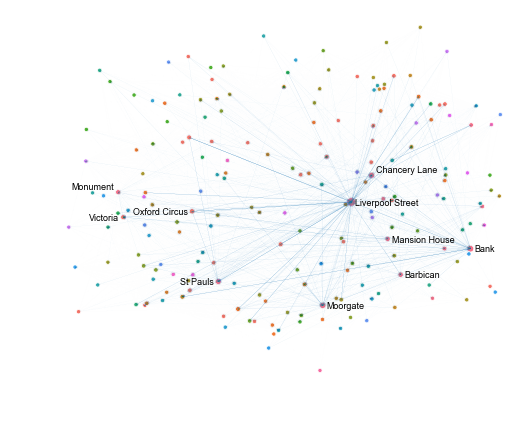

In [22]:
from simulate import get_pop_data
def data_to_draw(data_df):
    pop_data = get_pop_data()[0].set_index('Station')
    normalised_move = data_df.divide(pop_data['Population'], axis='index')

    coords_df, sim = form_coords_df(normalised_move)

    fig, ax = plt.subplots()
    fig.subplots_adjust(0, 0)
    ax = draw_graph(coords_df, sim, 200, hue='Local authority',
                            legend=False, rasterized=True, ax=ax)
    GAP = 0.01
    for row in coords_df.sort_values('connectivity', ascending=False)\
                .head(10).itertuples():
        if row.x < 0:
            ha = 'right'
            x = row.x - GAP
        else:
            ha = 'left'
            x = row.x + GAP
        y = row.y + GAP * row.y / abs(row.y)
        ax.text(s=row.Index, x=x, y=y, ha=ha, fontsize=9)
        ax.axis('off')
figs.set_size(7.5, .8)
data_to_draw(by_start_end)
plt.savefig('../../figs/Fig7.tif')